# Demo GPU computation
This demonstrates the use of low-level routines with a GPU.

### Generate fake data

In [1]:
from edge_iq.io import simulated_awgn

duration = 100e-3
fs = 15.36e6
analysis_bandwidth = 10e6

raw_iq = simulated_awgn(duration, fs)

### Analysis bandpass filter

In [2]:
from edge_iq import channel_analysis
from scipy import signal

sos = channel_analysis.generate_iir_lpf(
    rp_dB=0.1,
    rs_dB=70,
    cutoff_Hz=analysis_bandwidth/2,
    width_Hz=250e3,
    fs = fs,
).astype('float32')

%timeit -n1 -r1 signal.sosfilt(sos, raw_iq)
iq = signal.sosfilt(sos, raw_iq)

63 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [3]:
import cupy as cp
iq_gpu = cp.array(iq.copy())
%timeit -n1 -r1 cp.fft.fft(iq_gpu[:2*1024]).get()

273 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Channel power time-series

In [4]:
import iqwaveform
from edge_iq import channel_analysis

detector_period = 10e-3

pvt = channel_analysis.power_time_series(
    iq_gpu, fs=fs, detector_period=detector_period, detectors=('rms', 'peak')
)

print('cpu')
%timeit -n1 -r1 channel_analysis.power_time_series(iq, fs=fs, detector_period=detector_period, detectors=('rms', 'peak'))
print('gpu')
%timeit -n1 -r1 {n: a.get() for n, a in pvt.items()}
#channel_analysis.power_time_series(iq_gpu, fs=fs, detector_period=detector_period, detectors=('rms', 'peak'))

pvt = {n: a.get() for n, a in pvt.items()}

cpu
27.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
gpu
1.32 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


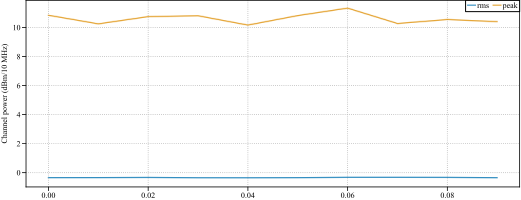

In [5]:
from iqwaveform import powtodB
from iqwaveform.env import set_caption
from matplotlib import pyplot as plt
import numpy as np

plt.style.use('iqwaveform.ieee_double_column')

for detector, trace in pvt.items():
    plt.plot(
        np.arange(trace.size)*detector_period,
        powtodB(trace),
        rasterized=True,
        label=detector
    )

plt.legend(ncol=3)
plt.title('power vs time M3 statistics', visible=False)
plt.ylabel('Channel power (dBm/10 MHz)');

### Cyclic channel power

In [20]:
from iqwaveform.power_analysis import iq_to_cyclic_power

cyclic_power_resolution = 1e-3/15/4

print('numpy:')
%timeit -n1 -r1 iq_to_cyclic_power(\
    iq, 1/fs,\
    cyclic_period=detector_period,\
    detector_period=cyclic_power_resolution,\
    detectors=list(pvt.keys()),\
    cycle_stats=('min', 'mean', 'max'),\
)

powerstats_cyclic_gpu = iq_to_cyclic_power(
    iq_gpu, 1/fs,
    cyclic_period=detector_period,
    detector_period=cyclic_power_resolution,
    detectors=list(pvt.keys()),
    cycle_stats=('min', 'mean', 'max'),
)
    
print('gpu:')
%timeit -n1 -r1 [[v2.get() for v2 in v.values()] for v in powerstats_cyclic_gpu.values()]

powerstats_cyclic = iq_to_cyclic_power(
    iq, 1/fs,
    cyclic_period=detector_period,
    detector_period=cyclic_power_resolution,
    detectors=list(pvt.keys()),
    cycle_stats=('min', 'mean', 'max'),
)



numpy:
30.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
gpu:
24.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
# from matplotlib.ticker import EngFormatter

# fig, ax = plt.subplots()

# for i, (detector, cyclic_traces) in enumerate(powerstats_cyclic.items()):
#     t = np.arange(cyclic_traces['mean'].size) * cyclic_power_resolution

#     ax.plot(t, powtodB(cyclic_traces['mean']), label=f'{detector} detector', color=f'C{i}', lw=1)

#     ax.fill_between(
#         t,
#         powtodB(cyclic_traces['min']),
#         powtodB(cyclic_traces['max']),
#         color=f'C{i}',
#         alpha=0.25,
#         lw=0,
#         rasterized=True,
#     )

# ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
# ax.legend()
# ax.set_xlabel('Cyclic lag')
# ax.set_ylabel('Channel power (dBm/10 MHz)')

# ax.set_title(f'Cyclic channel power evaluated with resolution {cyclic_power_resolution/1e-6:0.1f} us');

### Persistence Spectrum

In [8]:
frequency_resolution = 16e3
spectrum_quantiles = [0.1,0.25,0.5,0.75,0.9,0.95,0.99,0.999,1]

%timeit -n1 -r1 channel_analysis.persistence_spectrum(iq_gpu, fs=fs, window='flattop', fres=frequency_resolution, quantiles=spectrum_quantiles)
freqs, spectrum_gpu = channel_analysis.persistence_spectrum(iq_gpu, fs=fs, window='flattop', fres=frequency_resolution, quantiles=spectrum_quantiles)
spectrum_gpu = spectrum_gpu.get()
freqs, spectrum_np = channel_analysis.persistence_spectrum(iq, fs=fs, window='flattop', fres=frequency_resolution, quantiles=spectrum_quantiles)

75.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


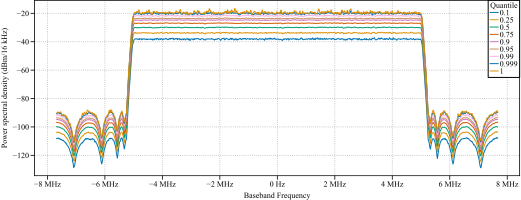

In [9]:
from matplotlib.ticker import EngFormatter
fig, ax = plt.subplots()

ax.plot(freqs, spectrum_gpu)
ax.legend(spectrum_quantiles, title='Quantile')
ax.set_xlabel('Baseband Frequency')
ax.xaxis.set_major_formatter(EngFormatter(unit='Hz'))
ax.set_ylabel(f'Power spectral density (dBm/{frequency_resolution/1e3:0.0f} kHz)');

### Amplitude Probability Distribution

408 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


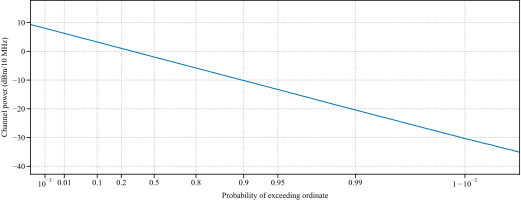

In [17]:
apd_bins = dict(power_low=-40, power_high=15, power_count=161)

%timeit -n1 -r1 channel_analysis.amplitude_probability_distribution(iq_gpu, **apd_bins)[0].get()
ccdf, bins = channel_analysis.amplitude_probability_distribution(iq_gpu, **apd_bins)

ccdf = ccdf.get()
bins = bins.get()

fig, ax = plt.subplots()
ax.plot(ccdf, bins);
ax.set_xscale('gamma-qq', k=1, major_ticks=16, db_ordinal=True)
ax.set_ylabel(f'Channel power (dBm/{analysis_bandwidth/1e6:0.0f} MHz)');
ax.set_xlabel('Probability of exceeding ordinate');